## Optional first step installing packages

In [20]:
import sys
!{sys.executable} -m pip install geofeather
!{sys.executable} -m pip install nhdnet  #see Setup info document 

### Loading modules

In [26]:
from pathlib import Path
import os
from time import time
import geopandas as gp
import geofeather

from geofeather import to_geofeather
from nhdnet.nhd.extract import extract_flowlines
#from nhdnet.nhd.extract, extract_waterbodies
from nhdnet.io import serialize_df, serialize_sindex, to_shp  # what does this do?

## Intial setup and constanst

In [30]:
#Select HUC of interest
HUC2 = 10
i = 19
HUC4 = "{0}{1:02d}".format(HUC2, i)  # this formats the HUC4 name how we want it. ':02d' is string formatting
print(HUC4)
print(type(HUC4))
huc_id = int(HUC4) * 1000000   # the full HUC4 ID
print(huc_id)

data_dir = Path("data/nhd/source/huc4")  # point to where GDBs are

#Setting projections
CRS = {           # Using USGS CONUS Albers (EPSG:102003): https://epsg.io/102003  WHY?
    "proj": "aea",
    "lat_1": 29.5,
    "lat_2": 45.5,
    "lat_0": 37.5,
    "lon_0": -96,
    "x_0": 0,
    "y_0": 0,
    "datum": "NAD83",
    "units": "m",
    "no_defs": True,
}

1019
<class 'str'>
1019000000


## Read in the geodatabase

In [31]:
# sys.path.append('/Users/rachelspinti/Documents/River_bifurcation/data/nhd/source/huc4/1029') #call where these scripts are located

gdb = data_dir/HUC4/ "NHDPLUS_H_{HUC4}_HU4_GDB.gdb".format(HUC4=HUC4)
print(gdb)
read_start = time()
flowlines, joins = extract_flowlines(gdb, target_crs=CRS)
print("Read {:,} flowlines in  {:.0f} seconds".format(len(flowlines), time() - read_start))

data/nhd/source/huc4/1019/NHDPLUS_H_1019_HU4_GDB.gdb
Reading flowlines
Read 232,511 flowlines
Reading VAA table and joining...
230,020 features after join to VAA
Filtering out loops and coastlines
221,415 features after removing loops and coastlines
Calculating size class
Converting MultiLineString => LineString
Converting geometry to 2D
projecting to target projection
Calculating length and sinuosity
Reading segment connections
Read 221,415 flowlines in  77 seconds


## Getting information about what came out of this

First for the flowlines -- this is a geodataframe with the flowline geometry. Comes from *flowlines.py*

In [55]:
type(flowlines)
flowlines.head(3)
# print(flowlines.describe)
# flowlines.plot()
# print(flowlines.shape)
# print(list(flowlines.columns))
# flowlines[flowlines.streamorder>6]
# flowlines[flowlines.streamorder>6].plot()

,geometry,lineID,NHDPlusID,FType,length,sinuosity,sizeclass,streamorder
0,"LINESTRING (-800081.762 215515.782, -800082.87...",1019000001,23001900008851,460,486.965546,1.082492,1a,1
1,"LINESTRING (-799823.525 221309.940, -799829.56...",1019000002,23001900008863,460,81.604347,1.008270,1a,1
2,"LINESTRING (-800259.206 220461.613, -800252.86...",1019000003,23001900008864,460,480.924530,1.016657,1a,1


Then for the joins - this is a dataframe with the linkage information. Comes from *flowlines.py*

In [54]:
type(joins)
joins.head(3)

# print(joins.describe)

,upstream,downstream,upstream_id,downstream_id,type
0,0,23001900145002,0,1019106322,origin
1,0,23001900145006,0,1019106326,origin
2,0,23001900145007,0,1019106327,origin


## Reorganizing the columns (not really sure why they do this)

In [56]:
flowlines= flowlines[["geometry",
                 "lineID",
                 "NHDPlusID",
                "FType",
                "length",
                "sinuosity",
                "sizeclass",
                "streamorder"]]
print(flowlines.shape)
#print(max(flowlines['NHDPlusID']), min(flowlines['NHDPlusID']))
print(max(flowlines['lineID']), min(flowlines['lineID']))



(221415, 8)
1019232510 1019000001


The lineIDs are created in *flowlines.py* 

In [62]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

# Calculate lineIDs to be unique across the regions
#LC - .loc Accesses a group of rows and columns by label(s) or a boolean array
flowlines["lineID"] += huc_id
# flowlines.head(3)

# Set updated lineIDs with the HUC4 prefix
joins.loc[joins.upstream_id != 0, "upstream_id"] += huc_id
joins.loc[joins.downstream_id != 0, "downstream_id"] += huc_id
# joins.head(3)

multi_table([flowlines.head(3), joins.head(3)])

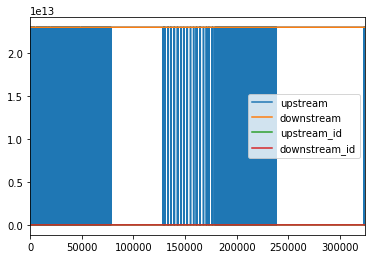

In [69]:
joins[joins.downstream_id>0].plot()

## Need to figure out what the read water bodies part is doing--- that function doesnt work in the sourced library but exists in the git repo
Check if we need to have the water bodies in order to have a fully connected drainage network or not

## Getting rid of dead ends
Note in this example there are none so nothing changes
~ means take the compliment

In [63]:
print(joins.shape)
joins=joins.loc[~((joins.downstream == 0) & (joins.upstream == 0))].copy()
print(joins.shape)

(311186, 5)
(311186, 5)


# Serializing the flowlines 
I think this means that the data structure is changed. So go from dataframe to feather file because it is easier to work with.

Blog post on to_geofeather: https://medium.com/@brendan_ward/introducing-geofeather-a-python-library-for-faster-geospatial-i-o-with-geopandas-341120d45ee5 
reset_index explanation: https://www.geeksforgeeks.org/reset-index-in-pandas-dataframe/

In [72]:
print("serializing {:,} flowlines to feather".format(len(flowlines)))
region_dir=data_dir/HUC4/ "NHDPLUS_H_{HUC4}_HU4_GDB.gdb".format(HUC4=HUC4)
# region_dir=Path(HUC4)
flowlines = flowlines.reset_index(drop=True)
to_geofeather(flowlines, region_dir /"flowlines.feather")
# #Serializes a pandas DataFrame to a feather file on disk --- just writing it efficiently
serialize_df(joins,  "flowline_joins.feather", index=False)


serializing 221,415 flowlines to feather


###  Not part of the workflow just testing out  joins to see how they made that table 
This is copied from extract.py

In [76]:
print("Reading flowline joins")

#this line reads the flowlines and grabs out just the columns 'FromNHDPID' and 'ToNHDPID' then it renames them as upstream and downstream
join_df = gp.read_file(gdb, layer="NHDPlusFlow")[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
join_df.upstream = join_df.upstream.astype("uint64")
join_df.downstream = join_df.downstream.astype("uint64")


join_df = (join_df.join(df.lineID.rename("upstream_id"), on="upstream").
          join(df.lineID.rename("downstream_id"), on="downstream")
          .fillna(0))

test=flowlines[0:3]
#print(test)
#print(test.FType)
#test.FType.rename("testing")
print(test)



Reading flowline joins


NameError: name 'df' is not defined

In [ ]:
#grabbing two columns out
print(join_df.shape)
test=join_df[["FromNHDPID", "ToNHDPID"]]
print(test.shape)
test.head(3)

In [53]:
#Grabbing two coulmns out and modifying 

test2=join_df[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
test2.head(3)

KeyError: "None of [Index(['FromNHDPID', 'ToNHDPID'], dtype='object')] are in the [columns]"

## Reading in the NABD shape file
Usefull tips on working with shape files: https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/

In [19]:
NABD = gp.read_file('./nabd_fish_barriers_2012/nabd_fish_barriers_2012.shp')


DriverError: ./nabd_fish_barriers_2012/nabd_fish_barriers_2012.shp: No such file or directory

In [ ]:
#look at the properties

In [ ]:
print(NABD.shape)
print(list(NABD.columns))
NABD.head(3)